## First model run with random forest

In [1]:
from loaddata import *
import numpy as np

import missingno as msno

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score  
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix, accuracy_score 

import matplotlib.pyplot as plt

R[write to console]: Warning:
R[write to console]:  namespace ‘pROC’ is not available and has been replaced
by .GlobalEnv when processing object ‘roc.objs’



In [2]:
for x in stopah.columns:
    if len(stopah[stopah[x] == -2147483648].index) >0:
        #print(x)
        ix = stopah[stopah[x] == -2147483648].index
        imp = stopah[[x]].loc[~stopah.index.isin(ix)].mean()[0]
        stopah.loc[ix,x] = imp

#stopah.min() check for more 

/tmp/ipykernel_2935647/1953162742.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  imp = stopah[[x]].loc[~stopah.index.isin(ix)].mean()[0]
/tmp/ipykernel_2935647/1953162742.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '181.05348615090736' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  stopah.loc[ix,x] = imp
/tmp/ipykernel_2935647/1953162742.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  imp = stopah[[x]].loc[~stopah.index.isin(ix)].mean()[0]
/tmp/ipykernel_2935647/1953162742.py:6: FutureWarn

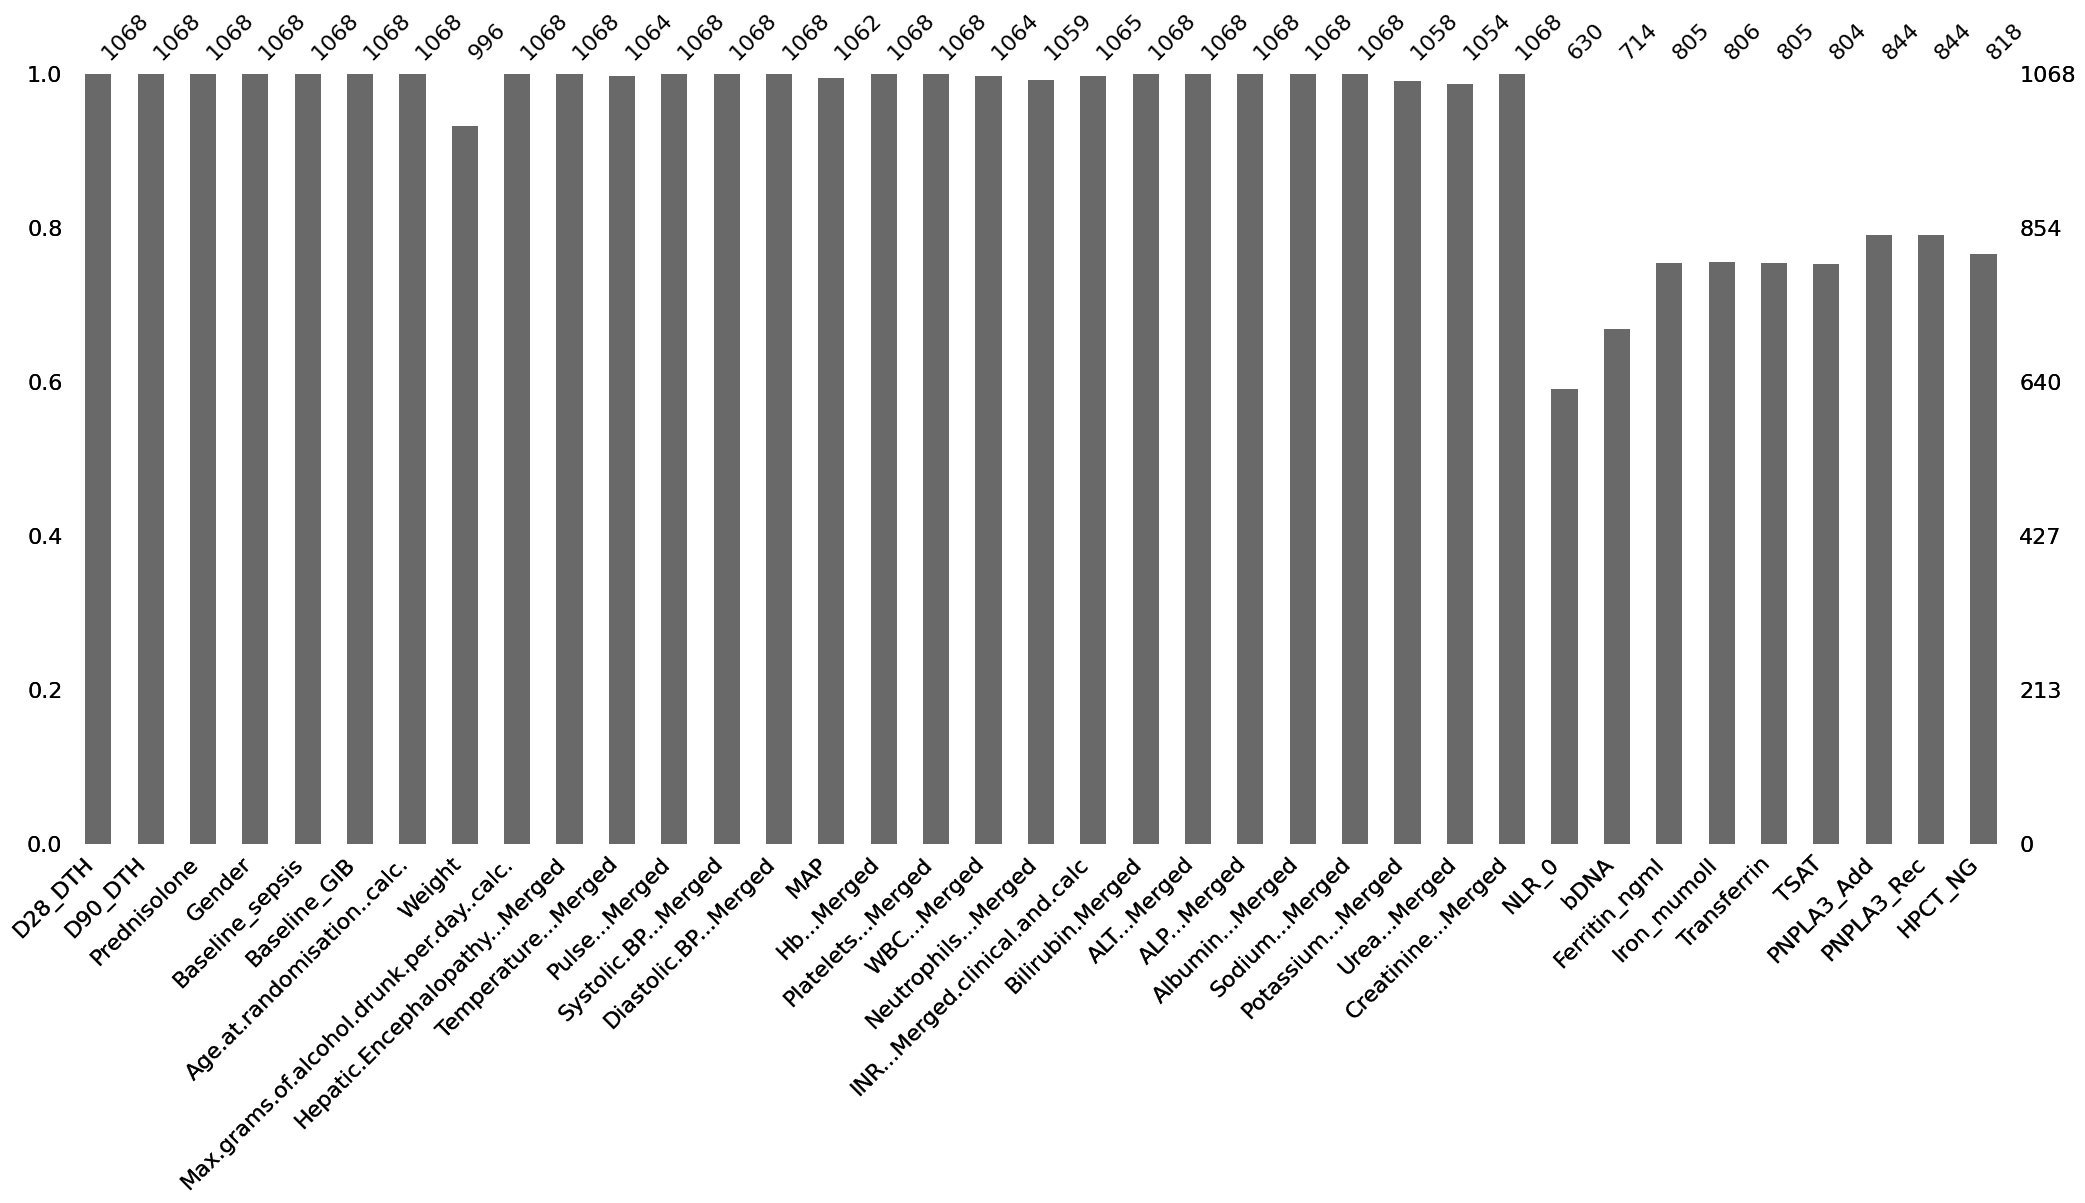

In [3]:
## Missing data situation

%matplotlib inline
msno.bar(stopah)
fig = msno.bar(stopah)
fig_copy = fig.get_figure()

In [4]:
# First crude Missing value management 

#Missing value management before train/test split. Controversial opinions, but I prefer the homogeneity


stopah['NLR_0'].isna().sum()/len(stopah) #remove, might be correlated to death or alive, but medical advice needed

stopah.drop(['NLR_0', 'bDNA'], axis=1, inplace=True) #same for 'bDNA'

baseline.remove('NLR_0')
baseline.remove('bDNA')

stopah[['Ferritin_ngml']].isna().sum()/len(stopah) #manageable amount 

baseline.remove('Ferritin_ngml')

In [9]:
stopah_copy = stopah.copy()

In [10]:
missing_mask = stopah_copy.isna()

In [78]:
imputer = IterativeImputer(max_iter=10, random_state=0)
imputed_values = imputer.fit_transform(stopah_copy)

/home/jlm217/.local/lib/python3.11/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [79]:
imputed_values

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.91641827],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.26157091],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.17386682],
       ...,
       [0.        , 0.        , 1.        , ..., 1.        , 0.        ,
        1.19967313],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.82757678],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [80]:
stopah.isna().sum().sum()

1872

In [81]:
type(imputed_values)

numpy.ndarray

In [ ]:
#MICE 
#stopah_copy = stopah.copy()
#missing_mask = stopah_copy.isna()
#imputer = IterativeImputer(max_iter=10, random_state=0)
#imputed_values = imputer.fit_transform(stopah_copy)

#stopah_copy[missing_mask] = imputed_values[missing_mask]

In [8]:
#MICE 
#stopah_copy = stopah.copy()
#missing_mask = stopah_copy.isna()
#imputer = IterativeImputer(max_iter=10, random_state=0)
#imputed_values = imputer.fit_transform(stopah_copy)

#stopah_copy[missing_mask] = imputed_values[missing_mask]

In [9]:
#not sure about 'PNPLA3_Add', 'PNPLA3_Rec', HPCT_NG, Hepatic.Encephalopathy...Merged

#categoricals and targets 

excluded = ['D28_DTH','D90_DTH','Prednisolone', 'Hepatic.Encephalopathy...Merged',
                                            'Baseline_sepsis','Baseline_GIB','Gender', 'HPCT_NG',
                                            'PNPLA3_Add', 'PNPLA3_Rec']

In [10]:
stopah[stopah.columns[~stopah.columns.isin(excluded)]] =stopah[stopah.columns[~stopah.columns.isin(excluded)]].apply(lambda x:np.log(x))

/home/jlm217/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [11]:
#Complete-case-analysis 
stopah = stopah.copy().dropna()

In [12]:
len(stopah) #big portion left out 

690

#### To do: Log scaling, hot-one-encoding, MICE on missings

In [13]:
#Split into train-test based on treatment 

train = stopah.loc[stopah['Prednisolone']==0].drop(['Prednisolone'], axis=1)

test= stopah.loc[stopah['Prednisolone']==1].drop(['Prednisolone'], axis=1)

train.reset_index()
test.reset_index()

,index,D28_DTH,D90_DTH,Gender,Baseline_sepsis,Baseline_GIB,Age.at.randomisation..calc.,Weight,Max.grams.of.alcohol.drunk.per.day..calc.,Hepatic.Encephalopathy...Merged,Temperature...Merged,Pulse...Merged,Systolic.BP...Merged,Diastolic.BP...Merged,MAP,Hb...Merged,Platelets...Merged,WBC...Merged,Neutrophils...Merged,INR...Merged.clinical.and.calc,Bilirubin.Merged,ALT...Merged,ALP...Merged,Albumin...Merged,Sodium...Merged,Potassium...Merged,Urea...Merged,Creatinine...Merged,Ferritin_ngml,Iron_mumoll,Transferrin,TSAT,PNPLA3_Add,PNPLA3_Rec,HPCT_NG
0,2,0,0,0,0,0,4.218036,4.290459,5.634790,1.0,3.597312,4.488636,4.605170,4.174387,4.339467,4.795791,4.634729,2.667228,2.501436,0.327814,5.774552,4.836282,5.755742,2.944439,4.912655,1.098612,2.251292,4.234107,8.630165,2.856470,4.394449,4.437934,0.0,0.0,0.261571
1,5,0,0,0,0,0,3.627004,4.284965,5.673323,0.0,3.602777,4.584967,4.795791,4.330733,4.510860,4.543295,5.093750,1.481605,1.131402,0.421726,4.983607,4.406719,4.828314,3.135494,4.905275,1.360977,0.000000,4.127134,7.513218,3.273364,4.812184,4.446174,2.0,1.0,0.204013
2,6,0,0,0,0,0,3.914021,4.318821,5.117994,0.0,3.610918,4.595120,4.905275,4.382027,4.588363,4.867534,3.871201,1.064711,0.641854,0.786966,6.109248,4.430817,4.521789,3.091042,4.905275,0.832909,0.693147,3.951244,7.368087,2.970414,4.394449,4.554929,0.0,0.0,0.000000
3,12,0,0,0,0,0,3.983413,4.430817,5.379897,0.0,3.597312,4.521789,4.828314,4.248495,4.481118,4.605170,4.762174,1.945910,1.568616,0.587787,5.247024,3.951244,5.187386,3.044522,4.927254,1.308333,1.589235,4.510860,6.658524,3.139833,4.905275,4.213608,1.0,0.0,0.113990
4,14,0,0,0,0,0,3.577948,4.453184,6.047372,0.0,3.605498,4.624973,4.744932,4.094345,4.360973,4.672829,4.499810,2.066863,1.704748,0.955511,4.955827,3.218876,5.087596,3.258097,4.779123,1.223775,1.629241,4.564348,7.372432,2.557227,3.988984,4.552824,1.0,0.0,0.154660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,1058,0,0,1,1,0,3.889777,3.933784,5.075174,0.0,3.602777,4.394449,4.709530,4.343805,4.481118,4.762174,5.438079,2.476538,2.208274,0.693147,5.293305,3.135494,5.533389,3.044522,4.867534,1.386294,0.955511,3.784190,7.112327,3.100092,4.595120,4.490881,0.0,0.0,0.273565
340,1061,0,0,1,0,0,3.325036,4.143135,5.375278,0.0,3.624341,4.682131,4.919981,4.330733,4.567814,4.691348,5.826000,2.839078,2.388763,0.693147,6.061457,3.091042,5.934894,3.258097,4.897840,0.916291,0.693147,3.637586,5.768633,2.923162,5.105945,3.790985,1.0,0.0,0.000000
341,1062,0,0,0,1,0,4.032469,4.449685,4.718499,0.0,3.608212,4.304065,4.624973,4.189655,4.356709,4.605170,4.304065,1.504077,1.064711,0.470004,5.476464,3.555348,4.836282,3.610918,4.919981,1.335001,1.029619,4.060443,6.517819,2.873565,4.317488,4.532599,1.0,0.0,0.000000
342,1066,0,0,1,0,0,3.921973,4.284965,4.406719,0.0,3.632309,4.615121,4.718499,4.356709,4.492375,4.691348,5.411646,3.194583,2.944439,0.530628,5.068904,3.367296,6.126869,3.295837,4.927254,1.458615,0.587787,3.688879,5.982928,2.484907,4.276666,4.201703,1.0,0.0,1.199673


In [14]:
##Class balances

deaths = ['D28_DTH','D90_DTH']

print('Training data')
for x in deaths:
    print(x.removesuffix('_DTH')+ ' deaths: ' + str(round(train[x].sum()*100/len(train),2)))

print('')

print('Test data')
for x in deaths:
     print(x.removesuffix('_DTH')+ ' deaths: ' + str(round(test[x].sum()*100/len(test),2)))

Training data
D28 deaths: 14.74
D90 deaths: 22.25

Test data
D28 deaths: 11.34
D90 deaths: 23.55


## Training at 28 days

In [15]:
X_train = train[baseline]
y_train = train['D28_DTH']

X_test = test[baseline]
y_test = test['D28_DTH']


In [16]:
#Balance weights
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train #provide your own target name
)


rf = RandomForestClassifier(n_estimators=15,max_depth=8,random_state=24,criterion='gini',min_samples_split=10)

In [17]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, min_samples_split=10, n_estimators=15,
                       random_state=24)

In [18]:
pred_prob = rf.predict_proba(X_test)

auc_score = roc_auc_score(y_test, pred_prob[:,1])

print('Training accuracy: ', np.mean(rf.predict(X_train) ==y_train)*100) 
print ('Test accuracy:', np.mean(rf.predict(X_test) ==y_test)*100)
print('AUC Score:',(auc_score)*100)

In [21]:
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

fpr, tpr, thresh = roc_curve(y_test, pred_prob[:,1], pos_label=1)

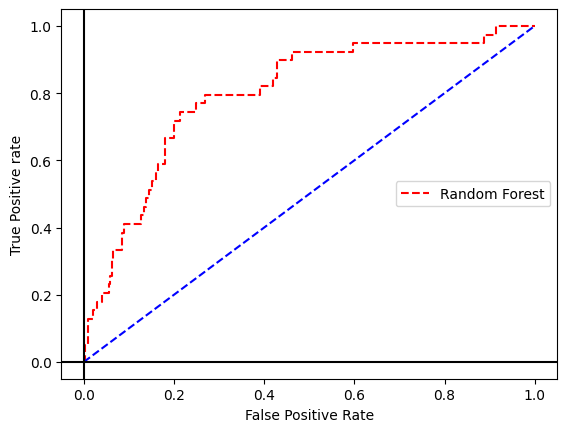

In [22]:
plt.axes(facecolor='white')
# plot roc curves

plt.plot(fpr, tpr, linestyle='--',color='red',label='Random Forest') #label='Random Forest'
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

#plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')
plt.grid(False)

plt.axhline(0, color='black')
plt.axvline(0, color='black')

#ax = fig.add_axes([1,1,0,0])

#ax.set_facecolor("white")

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

